# Modelo

## 01. Importar librerías

In [76]:
!pip install scikit-learn tensorflow pathlib


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
# -- Manejo de rutas ---
import pathlib

# --- Manejo de datos ---
import pandas as pd
import numpy as np
import ast

# --- Machine Learning / Red neuronal ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- Visualización (opcional, pero útil) ---
import matplotlib.pyplot as plt
import seaborn as sns


In [78]:
DATA_DIR = pathlib.Path().absolute().parent / "resultados_v5"

In [79]:
# Listar algunos archivos en el directorio de datos para verificar que existe
list(DATA_DIR.glob("*"))[:5]

[WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v5/W128_mu16_w4_eta2_a1_b10_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v5/W128_mu16_w4_eta2_a1_b15_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v5/W128_mu16_w4_eta2_a1_b20_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v5/W128_mu16_w4_eta2_a1_b25_binned_pow2.csv'),
 WindowsPath('c:/Users/Profesor/OneDrive - Universidad de los andes/Investigacion/Investigacion/resultados_v5/W128_mu16_w4_eta2_a1_b3_binned_pow2.csv')]

In [80]:
def parse_list(x):
    """Convierte columnas que vienen como strings '[1,2,3]' a listas reales"""
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return None
    return x

In [81]:
frames = []
files = []

if DATA_DIR.exists() and DATA_DIR.is_dir():
    for p in DATA_DIR.glob("*.csv"):
        try:
            df = pd.read_csv(p)

            # Parsear columnas que contienen listas en texto
            for col in ("edges_last", "NE_bin_avg", "C_bin_rate", "NE_pref_avg", "C_pref_rate"):
                if col in df.columns:
                    df[col] = df[col].apply(parse_list)

            df["__source__"] = p.name
            frames.append(df)
            files.append(p)
        except Exception as e:
            print(f"⚠️ No se pudo leer {p}: {e}")

if not frames:
    raise RuntimeError(f"❌ No se encontraron CSV en {DATA_DIR}")

df_all = pd.concat(frames, ignore_index=True)
print(f"✅ Archivos cargados: {len(files)} — Filas totales: {len(df_all)}")
print("Ejemplo de archivos:", [p.name for p in files[:5]])

✅ Archivos cargados: 72 — Filas totales: 72
Ejemplo de archivos: ['W128_mu16_w4_eta2_a1_b10_binned_pow2.csv', 'W128_mu16_w4_eta2_a1_b15_binned_pow2.csv', 'W128_mu16_w4_eta2_a1_b20_binned_pow2.csv', 'W128_mu16_w4_eta2_a1_b25_binned_pow2.csv', 'W128_mu16_w4_eta2_a1_b3_binned_pow2.csv']


In [82]:
# Revisar cuántos valores distintos de m_bins hay en el dataset
valores_unicos = df_all["m_bins"].unique()
print("Valores únicos de m_bins:", valores_unicos)
print("Cantidad de valores distintos:", len(valores_unicos))

# Conteo de frecuencia
conteo = df_all["m_bins"].value_counts().sort_index()
print("\nFrecuencia de cada m_bins:")
print(conteo)


Valores únicos de m_bins: [32  0]
Cantidad de valores distintos: 2

Frecuencia de cada m_bins:
m_bins
0     40
32    32
Name: count, dtype: int64


In [83]:
df_all.head()

,W,mu,w,eta,alpha,beta,N,N_valid,excluded_seeds,exception_failures,...,edges_last,NE_bin_avg,C_bin_rate,NE_pref_avg,C_pref_rate,excluded_rate,exception_rate,valid_failure_rate,seed,__source__
0,128,16,4,2,0.001,0.10,500,14,486,0,...,"[63653, 153287, 242921, 332555, 422189, 511823...","[11967.285714285714, 10206171.92857143, 140994...","[0.4286, 0.4286, 0.1429, 0.0, 0.0, 0.0, 0.0, 0...","[11967.285714285714, 10218139.214285715, 14201...","[0.4286, 0.8571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",0.972,0.0,0.0000,42,W128_mu16_w4_eta2_a1_b10_binned_pow2.csv
1,128,16,4,2,0.001,0.15,500,2,498,0,...,"[101381, 184764, 268147, 351530, 434913, 51829...","[52986.0, 35110535.0, 4997489351.0, 2034297460...","[0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[52986.0, 35163521.0, 5032652872.0, 2084623989...","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.996,0.0,0.0000,42,W128_mu16_w4_eta2_a1_b15_binned_pow2.csv
2,128,16,4,2,0.001,0.20,500,0,500,0,...,[],[],[],[],[],1.000,0.0,0.0000,42,W128_mu16_w4_eta2_a1_b20_binned_pow2.csv
3,128,16,4,2,0.001,0.25,500,0,500,0,...,[],[],[],[],[],1.000,0.0,0.0000,42,W128_mu16_w4_eta2_a1_b25_binned_pow2.csv
4,128,16,4,2,0.001,0.03,500,207,293,0,...,"[21594, 118047, 214500, 310953, 407406, 503859...","[1793.961352657005, 978404.7004830918, 1495037...","[0.8696, 0.0773, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1793.961352657005, 980198.6618357488, 1504839...","[0.8696, 0.9469, 0.9469, 0.9469, 0.9469, 0.946...",0.586,0.0,0.0531,42,W128_mu16_w4_eta2_a1_b3_binned_pow2.csv


In [84]:
import ast, numpy as np, pandas as pd

def _as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str) and x.strip().startswith('[') and x.strip().endswith(']'):
        try: return ast.literal_eval(x)
        except Exception: return None
    return None

def build_prefix_dataset(df_all: pd.DataFrame,
                         jeffreys: bool = True,
                         globalize: bool = True) -> pd.DataFrame:
    rows = []
    for _, r in df_all.iterrows():
        edges = _as_list(r.get("edges_last"))
        cbin  = _as_list(r.get("C_bin_rate"))
        cpref = _as_list(r.get("C_pref_rate"))
        if not (isinstance(edges, list) and len(edges) >= 2):
            continue
        m = len(edges) - 1
        if not isinstance(cpref, list) and isinstance(cbin, list) and len(cbin)==m:
            cpref = list(np.clip(np.cumsum(cbin), 0, 1))

        if not (isinstance(cpref, list) and len(cpref)==m):
            continue

        # Entradas del Alg. 7 (P se resume con α,β)
        W=float(r["W"]); w=float(r["w"]); mu=float(r["mu"]); eta=float(r["eta"])
        alpha=float(r["alpha"]); beta=float(r["beta"])
        Bmin=float(r.get("Bmin_avg", edges[0]))

        # Tamaños de muestra
        N=float(r.get("N", 0) or 0)
        N_valid = r.get("N_valid")
        if N_valid is None or (isinstance(N_valid, float) and np.isnan(N_valid)):
            N_valid = N - float(r.get("excluded_seeds",0) or 0) - float(r.get("errors",0) or 0)
        N_valid=float(max(0.0, N_valid))

        for k in range(m):
            B2=float(edges[k+1])
            base = float(cpref[k])                    # prob. sobre válidas hasta B2
            if jeffreys:                              # suavizado Jeffreys
                s = base * N_valid
                base = (s + 0.5) / (N_valid + 1.0) if N_valid>0 else base
            if globalize and N>0:                     # escala GLOBAL (cuenta excluidas/excepciones)
                base *= (N_valid / N)

            rows.append({
                "W":W,"w":w,"mu":mu,"eta":eta,"alpha":alpha,"beta":beta,
                "Bmin":Bmin,"B2":B2,
                "y_prefix": float(base),
                "group_id": f"W{int(W)}_w{int(w)}_mu{int(mu)}_eta{int(eta)}_a{alpha}_b{beta}",
                "k": k,
            })
    return pd.DataFrame(rows)

# Ejemplo de construcción:
df_prefix = build_prefix_dataset(df_all, jeffreys=True, globalize=True)

In [85]:
df_prefix.head(34)

,W,w,mu,eta,alpha,beta,Bmin,B2,y_prefix,group_id,k
0,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,153287.0,0.012134,W128_w4_mu16_eta2_a0.001_b0.1,0
1,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,242921.0,0.023332,W128_w4_mu16_eta2_a0.001_b0.1,1
2,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,332555.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,2
3,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,422189.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,3
4,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,511823.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,4
5,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,601457.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,5
6,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,691091.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,6
7,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,780725.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,7
8,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,870359.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,8
9,128.0,4.0,16.0,2.0,0.001,0.10,65942.0,959992.0,0.027067,W128_w4_mu16_eta2_a0.001_b0.1,9


In [86]:
import numpy as np, tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization
from tensorflow.keras import optimizers, callbacks

X_cols = ["W","w","mu","eta","alpha","beta","Bmin","B2"]
y_col  = "y_prefix"; g_col = "group_id"

X = df_prefix[X_cols].to_numpy(dtype="float32")
y = df_prefix[y_col].to_numpy(dtype="float32")
groups = df_prefix[g_col].to_numpy()

# split 80/20 por grupo
rng = np.random.default_rng(42)
uniq = np.unique(groups)
test_groups = set(rng.choice(uniq, size=max(1,int(0.2*len(uniq))), replace=False))
mask_te = np.array([g in test_groups for g in groups])
Xtr,Xte = X[~mask_te], X[mask_te]
ytr,yte = y[~mask_te], y[mask_te]
gtr,gte = groups[~mask_te], groups[mask_te]

# modelo
tf.random.set_seed(42)
norm = Normalization(); norm.adapt(Xtr)
model = Sequential([
    norm,
    Dense(32, activation="relu"),
    Dropout(0.1),
    Dense(16, activation="relu"),
    Dropout(0.1),
    Dense(8, activation="relu"),
    Dropout(0.1),
    Dense(4, activation="relu"),
    Dropout(0.1),
    Dense(2, activation="relu"),
    Dropout(0.1),
    Dense(1, activation="sigmoid")  # prob en (0,1)
])
model.compile(optimizer=optimizers.Adam(1e-3),
              loss="binary_crossentropy",             # funciona con etiquetas suaves
              metrics=[tf.keras.metrics.MeanSquaredError(name="brier_soft")])

es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5)

hist = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                 epochs=600, batch_size=1024,
                 callbacks=[es, rlr], verbose=1)


Epoch 1/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - brier_soft: 0.1541 - loss: 0.6913 - val_brier_soft: 0.1962 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 2/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - brier_soft: 0.1537 - loss: 0.6905 - val_brier_soft: 0.1958 - val_loss: 0.6888 - learning_rate: 0.0010
Epoch 3/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - brier_soft: 0.1533 - loss: 0.6897 - val_brier_soft: 0.1953 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 4/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - brier_soft: 0.1529 - loss: 0.6889 - val_brier_soft: 0.1947 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 5/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - brier_soft: 0.1523 - loss: 0.6877 - val_brier_soft: 0.1942 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 6/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - brier_soft: 0.1518 - loss: 0.6866 - val_brier_soft: 0.1936 - val_loss: 0.6845 - learning_rate: 0.0010
Epoch 7/600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - brier_soft: 0.1514 - loss:

In [87]:
# listar configuraciones disponibles
gids = df_prefix["group_id"].unique()
print(f"{len(gids)} configuraciones. Ejemplos:", gids[:5])

# elige una
GID = gids[0]   # o reemplaza por el que quieras


32 configuraciones. Ejemplos: ['W128_w4_mu16_eta2_a0.001_b0.1' 'W128_w4_mu16_eta2_a0.001_b0.15'
 'W128_w4_mu16_eta2_a0.001_b0.03' 'W128_w4_mu16_eta2_a0.001_b0.05'
 'W128_w4_mu2_eta2_a0.001_b0.1']


In [88]:
# asegúrate de tener X_cols definido como en el entrenamiento
rows = df_prefix.loc[df_prefix["group_id"]==GID].sort_values("B2")
X_cfg = rows[X_cols].to_numpy(dtype="float32")

# predicción P(score ∈ [Bmin, B2)) para cada corte B2 de esa config
p_hat_prefix = model.predict(X_cfg, verbose=0).ravel()

# probabilidad del bin puro [edge_k, edge_{k+1}) = diferencia de prefijos
p_hat_bin = np.diff(np.concatenate(([0.0], p_hat_prefix)))

print("GID:", GID)
print("B2 cortes:", rows["B2"].tolist())
print("P_hat prefix:", p_hat_prefix.tolist())
print("P_hat por bin:", p_hat_bin.tolist())
# el último prefijo es la probabilidad global estimada para esa configuración
print("P_global_hat:", float(p_hat_prefix[-1]))

GID: W128_w4_mu16_eta2_a0.001_b0.1
B2 cortes: [153287.0, 242921.0, 332555.0, 422189.0, 511823.0, 601457.0, 691091.0, 780725.0, 870359.0, 959992.0, 1049625.0, 1139258.0, 1228891.0, 1318524.0, 1408157.0, 1497790.0, 1587423.0, 1677056.0, 1766689.0, 1856322.0, 1945955.0, 2035588.0, 2125221.0, 2214854.0, 2304487.0, 2394120.0, 2483753.0, 2573386.0, 2663019.0, 2752652.0, 2842285.0, 2931918.0]
P_hat prefix: [0.04266425222158432, 0.04343215748667717, 0.04419340565800667, 0.044967420399188995, 0.04575430601835251, 0.04655430093407631, 0.04736761376261711, 0.048160478472709656, 0.04871118813753128, 0.049267854541540146, 0.04983057081699371, 0.050376348197460175, 0.050917115062475204, 0.051390498876571655, 0.05177248641848564, 0.05215717479586601, 0.05254453048110008, 0.05293462052941322, 0.053327448666095734, 0.053723011165857315, 0.05412135645747185, 0.05452248081564903, 0.05492641031742096, 0.055333130061626434, 0.05574270710349083, 0.05615512281656265, 0.05650344118475914, 0.05638766288757324,

,brier_soft,loss,val_brier_soft,val_loss,learning_rate
287,0.026871,0.379963,0.003952,0.216812,0.00050
288,0.025811,0.377873,0.003954,0.216813,0.00025
289,0.026521,0.380869,0.003956,0.216812,0.00025
290,0.024591,0.375572,0.003956,0.216807,0.00025
291,0.026005,0.378868,0.003956,0.216798,0.00025


Mejor época (val_loss): 276  |  val_loss=0.216711


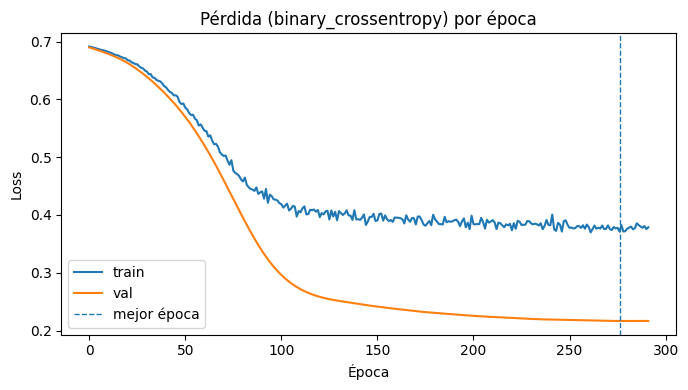

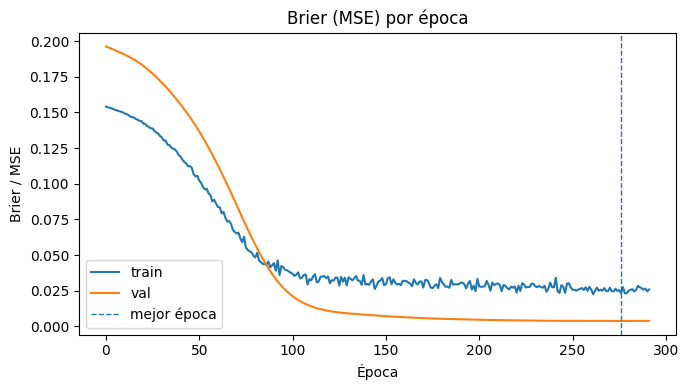

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Pasar el History a DataFrame
hist_df = pd.DataFrame(hist.history)
display(hist_df.tail(5))  # últimas 5 épocas

# 2) Mejor época según val_loss
best_ep = int(hist_df["val_loss"].idxmin())
best_val = float(hist_df.loc[best_ep, "val_loss"])
print(f"Mejor época (val_loss): {best_ep}  |  val_loss={best_val:.6f}")

# 3) Curva de pérdida
plt.figure(figsize=(7,4))
plt.plot(hist_df["loss"], label="train")
plt.plot(hist_df["val_loss"], label="val")
plt.axvline(best_ep, ls="--", lw=1, label="mejor época")
plt.title("Pérdida (binary_crossentropy) por época")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig("loss_curve.png", dpi=140); plt.show()

# 4) Curva del métrico (Brier soft = MSE)
if "brier_soft" in hist_df.columns:
    plt.figure(figsize=(7,4))
    plt.plot(hist_df["brier_soft"], label="train")
    if "val_brier_soft" in hist_df.columns:
        plt.plot(hist_df["val_brier_soft"], label="val")
    plt.axvline(best_ep, ls="--", lw=1, label="mejor época")
    plt.title("Brier (MSE) por época")
    plt.xlabel("Época"); plt.ylabel("Brier / MSE"); plt.legend()
    plt.tight_layout(); plt.savefig("brier_curve.png", dpi=140); plt.show()
else:
    print("⚠️ No encontré 'brier_soft' en hist.history. Columnas:", hist_df.columns.tolist())


In [90]:
import numpy as np

def brier_soft(y, p):
    return np.mean((y - p)**2)

def logloss_soft(y, p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

p_tr = model.predict(Xtr, verbose=0).ravel()
p_te = model.predict(Xte, verbose=0).ravel()

print("=== Métricas por-bin ===")
print("Train Brier:", round(brier_soft(ytr, p_tr), 6))
print("Test  Brier:", round(brier_soft(yte, p_te), 6))
print("Train LogLoss:", round(logloss_soft(ytr, p_tr), 6))
print("Test  LogLoss:", round(logloss_soft(yte, p_te), 6))

=== Métricas por-bin ===
Train Brier: 0.003161
Test  Brier: 0.003852
Train LogLoss: 0.319078
Test  LogLoss: 0.216711


In [91]:
import pandas as pd

df_eval = df_prefix.copy()
df_eval["y_hat"] = model.predict(df_prefix[X_cols].to_numpy(dtype="float32"), verbose=0).ravel()

# Tomar el último B2 (Bmax) de cada configuración
cfg_eval = (df_eval.sort_values(["group_id","B2"])
                   .groupby("group_id", as_index=False)
                   .tail(1)[["group_id","y_prefix","y_hat"]]
                   .rename(columns={"y_prefix":"p_true","y_hat":"p_pred"}))

err = cfg_eval["p_pred"] - cfg_eval["p_true"]
mae  = np.mean(np.abs(err))
rmse = np.sqrt(np.mean(err**2))
r2   = 1 - np.var(err)/np.var(cfg_eval["p_true"])
print("\n=== Métricas por configuración ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")



=== Métricas por configuración ===
MAE  = 0.0430
RMSE = 0.0596
R²   = 0.8363


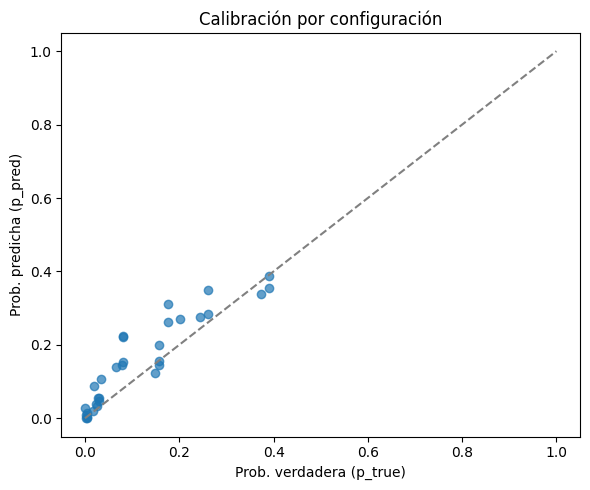

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(cfg_eval["p_true"], cfg_eval["p_pred"], alpha=0.7)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Prob. verdadera (p_true)")
plt.ylabel("Prob. predicha (p_pred)")
plt.title("Calibración por configuración")
plt.tight_layout()
plt.show()


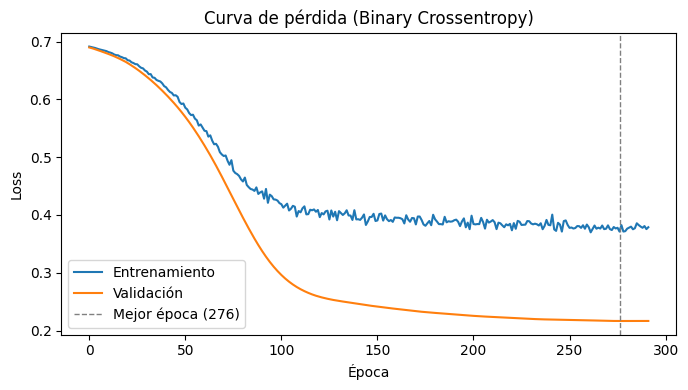

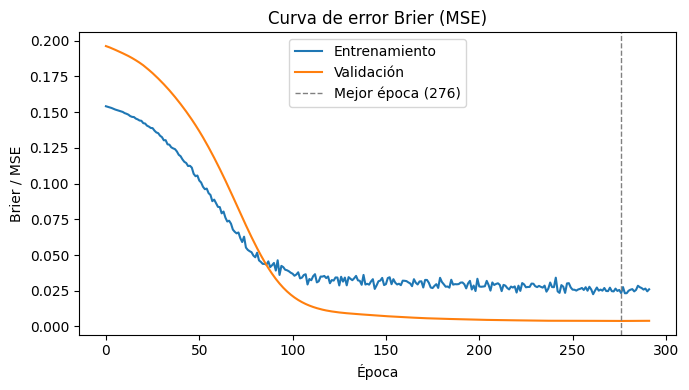

In [93]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1️⃣ Curvas de pérdida y Brier (usando tu hist) ---
hist_df = pd.DataFrame(hist.history)
best_ep = int(hist_df["val_loss"].idxmin())

plt.figure(figsize=(7,4))
plt.plot(hist_df["loss"], label="Entrenamiento")
plt.plot(hist_df["val_loss"], label="Validación")
plt.axvline(best_ep, color="gray", linestyle="--", lw=1, label=f"Mejor época ({best_ep})")
plt.title("Curva de pérdida (Binary Crossentropy)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_summary.png", dpi=140)
plt.show()

if "brier_soft" in hist_df.columns:
    plt.figure(figsize=(7,4))
    plt.plot(hist_df["brier_soft"], label="Entrenamiento")
    plt.plot(hist_df["val_brier_soft"], label="Validación")
    plt.axvline(best_ep, color="gray", linestyle="--", lw=1, label=f"Mejor época ({best_ep})")
    plt.title("Curva de error Brier (MSE)")
    plt.xlabel("Época")
    plt.ylabel("Brier / MSE")
    plt.legend()
    plt.tight_layout()
    plt.savefig("brier_curve_summary.png", dpi=140)
    plt.show()


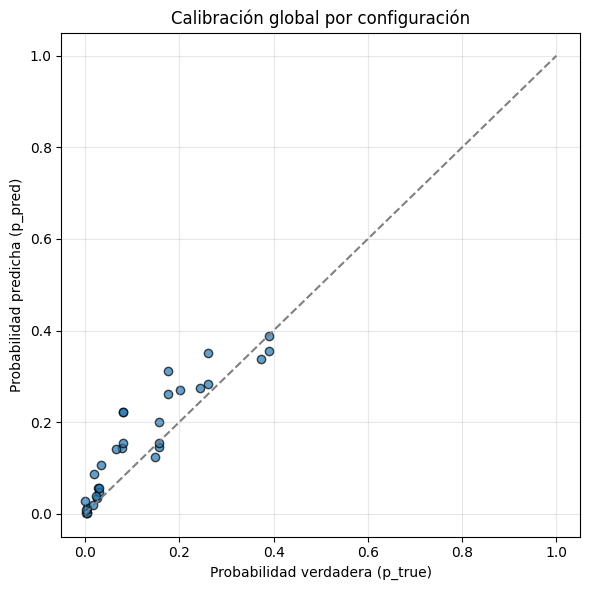

In [94]:
# Dataset agregado (usa df_eval o cfg_eval según tu código)
df_eval = df_prefix.copy()
df_eval["y_hat"] = model.predict(df_prefix[X_cols].to_numpy(dtype="float32"), verbose=0).ravel()

cfg_eval = (df_eval.sort_values(["group_id","B2"])
                   .groupby("group_id", as_index=False)
                   .tail(1)[["group_id","y_prefix","y_hat"]]
                   .rename(columns={"y_prefix":"p_true","y_hat":"p_pred"}))

plt.figure(figsize=(6,6))
plt.scatter(cfg_eval["p_true"], cfg_eval["p_pred"], alpha=0.7, edgecolor="k")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("Probabilidad verdadera (p_true)")
plt.ylabel("Probabilidad predicha (p_pred)")
plt.title("Calibración global por configuración")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("calibracion_global.png", dpi=140)
plt.show()


In [95]:
# ✅ Guarda el modelo completo (recomendado en TF ≥2.12)
model.save("modelo.keras")   # crea archivo compacto (~2–3 MB)

In [96]:
# ======================= Ranking de modelos + historiales =======================
import os, time, json, numpy as np, tensorflow as tf, pandas as pd
from tensorflow.keras import layers, models, optimizers, callbacks, losses, metrics

# ---------- Constructor de modelos parametrizable ----------
def make_keras_model(input_dim,
                     hidden_layers=(64,64),
                     dropout=0.2,
                     use_batchnorm=False,
                     lr=1e-3,
                     loss_name="mse",   # "mse" | "huber" | "bce" | "bce_ls"
                     huber_delta=0.1,
                     label_smoothing=0.0):
    """
    MLP para probabilidad calibrada con Normalization al inicio y sigmoide al final.
    """
    inp = layers.Input(shape=(input_dim,), dtype="float32")
    norm = layers.Normalization()
    x = norm(inp)
    for h in hidden_layers:
        x = layers.Dense(h, activation="relu")(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    # Pérdida
    if loss_name == "mse":
        loss_fn = losses.MeanSquaredError()
    elif loss_name == "huber":
        loss_fn = losses.Huber(delta=float(huber_delta))
    elif loss_name == "bce":
        loss_fn = losses.BinaryCrossentropy()
    elif loss_name == "bce_ls":
        loss_fn = losses.BinaryCrossentropy(label_smoothing=float(label_smoothing))
    else:
        raise ValueError(f"loss desconocida: {loss_name}")

    model = models.Model(inp, out)
    model.compile(
        optimizer=optimizers.Adam(lr),
        loss=loss_fn,
        metrics=[
            metrics.MeanSquaredError(name="brier"),      # Brier = MSE sobre probas
            metrics.BinaryCrossentropy(name="nll")       # NLL como referencia
        ]
    )
    return model, norm


# ---------- Runner + ranking (con historiales y fix de forma y∈R^{n×1}) ----------
def run_and_rank(
    Xtr, ytr, Xte, yte,
    arch_space,                     # lista de dicts con configs de make_keras_model
    out_dir="exp_ranked",
    max_epochs=300, batch_size=1024,
    seed=42, verbose=True,
    save_history_json=True
):
    """
    Entrena un experimento por configuración en arch_space:
      - Guarda best_<tag>.keras (mejor checkpoint por val_loss)
      - Guarda <tag>_history.csv (+ .json opcional) con curvas por época
      - Crea ranking.csv ordenado por val_min, test_brier, test_nll
    Devuelve: (df_ranking, best_model, best_path)
    """
    os.makedirs(out_dir, exist_ok=True)
    np.random.seed(seed); tf.random.set_seed(seed)

    # ---- Asegurar forma 2D en etiquetas: (n,1) ----
    ytr2 = np.asarray(ytr, dtype="float32")
    yte2 = np.asarray(yte, dtype="float32")
    if ytr2.ndim == 1: ytr2 = ytr2[:, None]
    if yte2.ndim == 1: yte2 = yte2[:, None]

    rows = []

    for i, cfg in enumerate(arch_space, 1):
        tag = cfg.get("tag") or (
            f"h{cfg.get('hidden_layers')}_do{cfg.get('dropout',0)}"
            f"_bn{int(cfg.get('use_batchnorm',False))}_{cfg.get('loss','mse')}"
            f"{('_d'+str(cfg.get('huber_delta'))) if cfg.get('loss')=='huber' else ''}"
            f"{('_ls'+str(cfg.get('label_smoothing'))) if cfg.get('loss')=='bce_ls' else ''}"
        )
        if verbose:
            print(f"\n=== [{i}/{len(arch_space)}] {tag} ===")

        # Construir modelo
        model, norm = make_keras_model(
            input_dim=Xtr.shape[1],
            hidden_layers=cfg.get("hidden_layers", (64,64)),
            dropout=cfg.get("dropout", 0.2),
            use_batchnorm=cfg.get("use_batchnorm", False),
            lr=cfg.get("lr", 1e-3),
            loss_name=cfg.get("loss", "mse"),
            huber_delta=cfg.get("huber_delta", 0.1),
            label_smoothing=cfg.get("label_smoothing", 0.0)
        )
        # Adaptar normalizador
        norm.adapt(Xtr)

        ckpt_path = os.path.join(out_dir, f"best_{tag}.keras")
        es  = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
        rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-5)
        ck  = callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)

        # Entrenamiento
        t0 = time.time()
        hist = model.fit(
            Xtr, ytr2,
            validation_data=(Xte, yte2),
            epochs=max_epochs, batch_size=batch_size,
            callbacks=[es, rlr, ck],
            verbose=0
        )
        dt = time.time() - t0

        # Guardar historial por época
        hist_df = pd.DataFrame(hist.history)
        hist_df.insert(0, "epoch", np.arange(1, len(hist_df)+1))
        hist_csv = os.path.join(out_dir, f"{tag}_history.csv")
        hist_df.to_csv(hist_csv, index=False)
        if save_history_json:
            with open(os.path.join(out_dir, f"{tag}_history.json"), "w") as f:
                json.dump(hist.history, f, indent=2)

        # Cargar mejor checkpoint
        try:
            best = tf.keras.models.load_model(ckpt_path)
        except Exception:
            best = model

        # Evaluación final (usa yte2 en forma 2D)
        te_loss, te_brier, te_nll = best.evaluate(Xte, yte2, verbose=0)
        val_min = float(np.min(hist.history["val_loss"]))

        row = {
            "tag": tag,
            **cfg,
            "epochs": len(hist.history["loss"]),
            "train_time_s": round(dt, 2),
            "val_min": float(val_min),
            "test_loss": float(te_loss),
            "test_brier": float(te_brier),
            "test_nll": float(te_nll),
            "model_path": ckpt_path,
            "history_csv": hist_csv
        }
        rows.append(row)

        if verbose:
            print(f"val_min={val_min:.4f}  test_brier={te_brier:.4f}  test_nll={te_nll:.4f}")
            print(f"→ checkpoint: {ckpt_path}")
            print(f"→ history:    {hist_csv}")

    # Ranking y carga del mejor
    df = pd.DataFrame(rows)
    df_sorted = df.sort_values(["val_min", "test_brier", "test_nll"],
                               ascending=[True, True, True]).reset_index(drop=True)
    df_sorted.to_csv(os.path.join(out_dir, "ranking.csv"), index=False)

    best_path = df_sorted.iloc[0]["model_path"]
    best_model = tf.keras.models.load_model(best_path)

    if verbose:
        print("\n=== TOP 5 ===")
        print(df_sorted.head(5)[["tag","val_min","test_brier","test_nll","model_path","history_csv"]])
        print(f"\nMejor modelo: {best_path}")

    return df_sorted, best_model, best_path


In [97]:
# ======================= ARCH_SPACE AMPLIADO (30 variantes) =======================
arch_space = [
    # --- Shallow (rápidos/estables) ---
    {"tag":"shallow32_mse",        "hidden_layers":(32,32),            "dropout":0.1, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow64_mse",        "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow64_bn_mse",     "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow128_64_mse",    "hidden_layers":(128,64),           "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"shallow64_huber005",   "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"huber", "huber_delta":0.05},
    {"tag":"shallow64_huber010",   "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"huber", "huber_delta":0.10},
    {"tag":"shallow64_huber015",   "hidden_layers":(64,64),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"huber", "huber_delta":0.15},
    {"tag":"shallow32_bce_ls03",   "hidden_layers":(32,32),            "dropout":0.2, "use_batchnorm":False, "lr":1e-3,  "loss":"bce_ls","label_smoothing":0.03},

    # --- Mid (un poco más de capacidad) ---
    {"tag":"mid_128_128_mse",      "hidden_layers":(128,128),          "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_128_128_lr5e4",    "hidden_layers":(128,128),          "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"mid_128_64_32_mse",    "hidden_layers":(128,64,32),        "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_128_64_32_h010",   "hidden_layers":(128,64,32),        "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"huber","huber_delta":0.10},
    {"tag":"mid_96_64_32_mse",     "hidden_layers":(96,64,32),         "dropout":0.15,"use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_96_64_32_lr5e4",   "hidden_layers":(96,64,32),         "dropout":0.15,"use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"mid_64_64_64_mse",     "hidden_layers":(64,64,64),         "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"mid_64_64_64_h005",    "hidden_layers":(64,64,64),         "dropout":0.2, "use_batchnorm":True,  "lr":1e-3,  "loss":"huber","huber_delta":0.05},

    # --- Deep (si notas underfit) ---
    {"tag":"deep_256_128_64_mse",  "hidden_layers":(256,128,64),       "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"deep_256_128_64_h010", "hidden_layers":(256,128,64),       "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"huber","huber_delta":0.10},
    {"tag":"deep_128x4_mse",       "hidden_layers":(128,128,128,128),  "dropout":0.15,"use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"deep_128x4_h005",      "hidden_layers":(128,128,128,128),  "dropout":0.15,"use_batchnorm":True,  "lr":5e-4,  "loss":"huber","huber_delta":0.05},
    {"tag":"deep_96x5_mse",        "hidden_layers":(96,96,96,96,96),   "dropout":0.1, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},

    # --- Wide & Shallow (si hay no linealidades suaves) ---
    {"tag":"wide_256_128_mse",     "hidden_layers":(256,128),          "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"wide_256_128_h015",    "hidden_layers":(256,128),          "dropout":0.2, "use_batchnorm":True,  "lr":5e-4,  "loss":"huber","huber_delta":0.15},
    {"tag":"wide_320_160_mse",     "hidden_layers":(320,160),          "dropout":0.25,"use_batchnorm":True,  "lr":5e-4,  "loss":"mse"},
    {"tag":"wide_192_96_bce_ls05", "hidden_layers":(192,96),           "dropout":0.2, "use_batchnorm":True,  "lr":7e-4,  "loss":"bce_ls","label_smoothing":0.05},

    # --- Regularización fuerte (si hay overfit) ---
    {"tag":"reg_64_32_16_mse",     "hidden_layers":(64,32,16),         "dropout":0.3, "use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"reg_64_32_16_h010",    "hidden_layers":(64,32,16),         "dropout":0.3, "use_batchnorm":True,  "lr":1e-3,  "loss":"huber","huber_delta":0.10},
    {"tag":"reg_48_24_12_mse",     "hidden_layers":(48,24,12),         "dropout":0.35,"use_batchnorm":True,  "lr":1e-3,  "loss":"mse"},
    {"tag":"reg_32_16_8_bce_ls03", "hidden_layers":(32,16,8),          "dropout":0.3, "use_batchnorm":False, "lr":1e-3,  "loss":"bce_ls","label_smoothing":0.03},

    # --- “Tiny” (baseline/ablation) ---
    {"tag":"tiny_16_16_mse",       "hidden_layers":(16,16),            "dropout":0.1, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
    {"tag":"tiny_16_8_mse",        "hidden_layers":(16,8),             "dropout":0.1, "use_batchnorm":False, "lr":1e-3,  "loss":"mse"},
]

In [98]:
# Asegúrate de tener Xtr, ytr, Xte, yte (float32); y* en [0,1]
df_rank, best_model, best_path = run_and_rank(
    Xtr, ytr, Xte, yte,
    arch_space=arch_space,
    out_dir="exp_ranked_models",
    max_epochs=300, batch_size=1024,
    seed=42, verbose=True
)


=== [1/31] shallow32_mse ===
val_min=0.0026  test_brier=0.0026  test_nll=0.2135
→ checkpoint: exp_ranked_models\best_shallow32_mse.keras
→ history:    exp_ranked_models\shallow32_mse_history.csv

=== [2/31] shallow64_mse ===
val_min=0.0014  test_brier=0.0014  test_nll=0.2068
→ checkpoint: exp_ranked_models\best_shallow64_mse.keras
→ history:    exp_ranked_models\shallow64_mse_history.csv

=== [3/31] shallow64_bn_mse ===
val_min=0.0023  test_brier=0.0023  test_nll=0.2184
→ checkpoint: exp_ranked_models\best_shallow64_bn_mse.keras
→ history:    exp_ranked_models\shallow64_bn_mse_history.csv

=== [4/31] shallow128_64_mse ===
val_min=0.0110  test_brier=0.0110  test_nll=0.2601
→ checkpoint: exp_ranked_models\best_shallow128_64_mse.keras
→ history:    exp_ranked_models\shallow128_64_mse_history.csv

=== [5/31] shallow64_huber005 ===
val_min=0.0007  test_brier=0.0016  test_nll=0.2073
→ checkpoint: exp_ranked_models\best_shallow64_huber005.keras
→ history:    exp_ranked_models\shallow64_huber

Tag detectado: deep_128x4_h005
Historial esperado: exp_ranked_models\deep_128x4_h005_history.csv


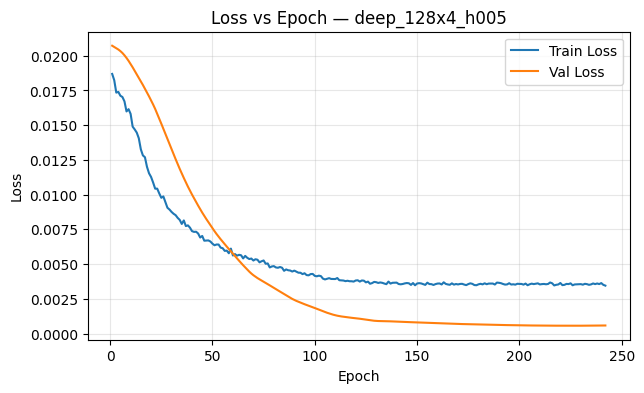

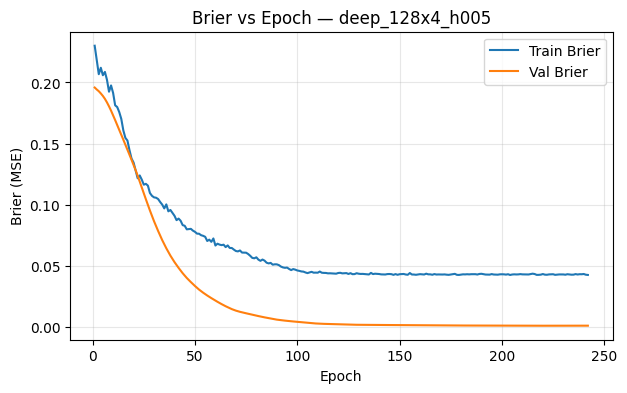

Predicciones test → min/mean/max: 0.033969 / 0.078836 / 0.135666
Brier_ext=0.0011  NLL_ext=0.2092


In [99]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# --- 1) Cargar el mejor modelo desde best_path y (opcional) guardarlo con nombre final ---
best_path = Path(best_path)  # viene de run_and_rank
best_model = tf.keras.models.load_model(best_path)
best_model.save("modelo_prefijo_FINAL.keras")  # duplicado con nombre estable

# --- 2) Encontrar el CSV de historial a partir del nombre del checkpoint ---
# Formato del checkpoint: out_dir / f"best_{tag}.keras"
tag = best_path.stem.replace("best_", "")              # e.g., "shallow64_mse"
hist_csv = best_path.parent / f"{tag}_history.csv"     # e.g., exp_ranked_models/shallow64_mse_history.csv"

print("Tag detectado:", tag)
print("Historial esperado:", hist_csv)

# --- 3) Cargar historial y graficar ---
if hist_csv.exists():
    hist = pd.read_csv(hist_csv)

    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(hist["epoch"], hist["loss"], label="Train Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch — {tag}")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # Brier (si está)
    if "brier" in hist.columns and "val_brier" in hist.columns:
        plt.figure(figsize=(7,4))
        plt.plot(hist["epoch"], hist["brier"], label="Train Brier")
        plt.plot(hist["epoch"], hist["val_brier"], label="Val Brier")
        plt.xlabel("Epoch"); plt.ylabel("Brier (MSE)")
        plt.title(f"Brier vs Epoch — {tag}")
        plt.legend(); plt.grid(True, alpha=0.3)
        plt.show()
else:
    print(f"⚠️ No se encontró el historial: {hist_csv}")

# --- 4) (Opcional) Métricas rápidas en test ---
p_te = best_model.predict(Xte, verbose=0).ravel()
p_te = np.clip(p_te, 1e-6, 1-1e-6)
y_true = np.asarray(yte).ravel().astype("float32")

from sklearn.metrics import mean_squared_error
brier = mean_squared_error(y_true, p_te)
import tensorflow as tf
nll = float(tf.keras.losses.BinaryCrossentropy()(y_true, p_te).numpy())

print(f"Predicciones test → min/mean/max: {p_te.min():.6f} / {p_te.mean():.6f} / {p_te.max():.6f}")
print(f"Brier_ext={brier:.4f}  NLL_ext={nll:.4f}")


In [100]:
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf

y = np.asarray(y_true).ravel().astype("float32")
p = np.asarray(p_hat).ravel().astype("float32")
p = np.clip(p, 1e-6, 1-1e-6)

# Brier del modelo
brier_model = mean_squared_error(y, p)

# Baseline: siempre predecir la media empírica
p_base = np.full_like(p, y.mean(), dtype="float32")
brier_base = mean_squared_error(y, p_base)

# Brier Skill Score (1 = perfecto, 0 = igual al baseline, <0 peor que baseline)
BSS = 1.0 - (brier_model / brier_base)

# NLL (BCE) del modelo y del baseline (etiquetas suaves)
nll_model = float(tf.keras.losses.BinaryCrossentropy()(y, p).numpy())
nll_base  = float(tf.keras.losses.BinaryCrossentropy()(y, np.clip(p_base,1e-6,1-1e-6)).numpy())

print(f"Brier(model)={brier_model:.6f}  Brier(base)={brier_base:.6f}  BSS={BSS:.4f}")
print(f"NLL(model)={nll_model:.6f}     NLL(base)={nll_base:.6f}")


Brier(model)=0.002564  Brier(base)=0.002605  BSS=0.0156
NLL(model)=0.214364     NLL(base)=0.221561


In [101]:
import numpy as np
import pandas as pd

def calibration_stats(y_true, p_hat, n_bins=10):
    y = np.asarray(y_true).ravel().astype("float32")
    p = np.asarray(p_hat).ravel().astype("float32")

    bins = np.linspace(0.0, 1.0, n_bins+1)
    idx  = np.digitize(p, bins) - 1
    idx  = np.clip(idx, 0, n_bins-1)

    rows = []
    for k in range(n_bins):
        m = (idx == k)
        n_k = int(m.sum())
        if n_k == 0:
            rows.append((k, bins[k], bins[k+1], np.nan, np.nan, 0))
            continue
        conf_k = float(p[m].mean())
        acc_k  = float(y[m].mean())
        rows.append((k, bins[k], bins[k+1], conf_k, acc_k, n_k))

    df = pd.DataFrame(rows, columns=["bin","lo","hi","confidence","accuracy","count"])
    # Expected Calibration Error
    w = df["count"].to_numpy(dtype="float64")
    gap = np.abs(df["confidence"] - df["accuracy"]).to_numpy(dtype="float64")
    ece = float(np.nansum((w / np.nansum(w)) * gap)) if np.nansum(w) > 0 else np.nan
    mce = float(np.nanmax(gap))
    return df, ece, mce

df_cal, ECE, MCE = calibration_stats(y_true, p_hat, n_bins=10)
print("ECE=", round(ECE,4), " MCE=", round(MCE,4))
print(df_cal)

# (Opcional) plot rápido:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6,6))
# plt.plot([0,1],[0,1], linestyle="--")
# plt.scatter(df_cal["confidence"], df_cal["accuracy"])
# plt.xlabel("Confianza promedio (p̂)"); plt.ylabel("Frecuencia empírica (y)")
# plt.title(f"Reliability plot — ECE={ECE:.3f}")
# plt.grid(True, alpha=0.3); plt.gca().set_aspect("equal", adjustable="box")
# plt.show()


ECE= 0.0203  MCE= 0.0625
   bin   lo   hi  confidence  accuracy  count
0    0  0.0  0.1    0.049550  0.051654    134
1    1  0.1  0.2    0.135271  0.072817     58
2    2  0.2  0.3         NaN       NaN      0
3    3  0.3  0.4         NaN       NaN      0
4    4  0.4  0.5         NaN       NaN      0
5    5  0.5  0.6         NaN       NaN      0
6    6  0.6  0.7         NaN       NaN      0
7    7  0.7  0.8         NaN       NaN      0
8    8  0.8  0.9         NaN       NaN      0
9    9  0.9  1.0         NaN       NaN      0


Sharpness (var p̂) = 0.001988   |   std(p̂) = 0.044581
min/mean/max p̂ = 0.016607 / 0.075445 / 0.156825


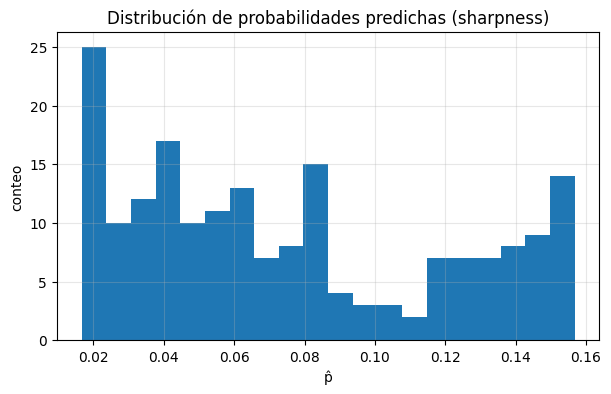

In [102]:
import numpy as np
import matplotlib.pyplot as plt

p = np.asarray(p_hat).ravel().astype("float32")
sharpness = float(np.var(p))     # varianza de las probabilidades predichas
spread    = float(np.std(p))     # desviación estándar (solo informativa)

print(f"Sharpness (var p̂) = {sharpness:.6f}   |   std(p̂) = {spread:.6f}")
print(f"min/mean/max p̂ = {p.min():.6f} / {p.mean():.6f} / {p.max():.6f}")

# (Opcional) histograma sin estilos fijos
plt.figure(figsize=(7,4))
plt.hist(p, bins=20)
plt.xlabel("p̂"); plt.ylabel("conteo")
plt.title("Distribución de probabilidades predichas (sharpness)")
plt.grid(True, alpha=0.3); plt.show()


In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf

# --- 1. Asegúrate de usar el mejor modelo ---
model = tf.keras.models.load_model("modelo_prefijo_FINAL.keras")

# --- 2. Predicciones sobre todo el dataset ---
df_eval = df_prefix.copy()
df_eval["y_hat"] = model.predict(df_prefix[X_cols].to_numpy(dtype="float32"), verbose=0).ravel()

# --- 3. Tomar el último B2 (Bmax) por configuración ---
cfg_eval = (
    df_eval.sort_values(["group_id","B2"])
           .groupby("group_id", as_index=False)
           .tail(1)[["group_id","y_prefix","y_hat"]]
           .rename(columns={"y_prefix":"p_true","y_hat":"p_pred"})
)

# --- 4. Métricas ---
err  = cfg_eval["p_pred"] - cfg_eval["p_true"]
mae  = np.mean(np.abs(err))
rmse = np.sqrt(np.mean(err**2))
r2   = 1 - np.var(err)/np.var(cfg_eval["p_true"])

print("\n=== Métricas por configuración ===")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

# --- 5. (Opcional) muestra top-5 configuraciones con mayor error ---
cfg_eval["abs_err"] = np.abs(err)
print("\nTop 5 con mayor error:")
print(cfg_eval.sort_values("abs_err", ascending=False).head())



=== Métricas por configuración ===
MAE  = 0.0973
RMSE = 0.1949
R²   = -1.6532

Top 5 con mayor error:
                           group_id    p_true    p_pred   abs_err
127  W128_w4_mu16_eta2_a0.001_b0.05  0.175110  0.994122  0.819011
95   W128_w4_mu16_eta2_a0.001_b0.03  0.391127  0.997909  0.606782
447   W128_w4_mu8_eta2_a0.001_b0.03  0.391127  0.159220  0.231907
319   W128_w4_mu4_eta2_a0.001_b0.03  0.373098  0.177434  0.195664
543  W192_w4_mu16_eta2_a0.001_b0.03  0.261047  0.131465  0.129582


In [104]:
import numpy as np
import pandas as pd
import tensorflow as tf

def predict_config_prefix_bins(model, df_prefix, GID, X_cols, eps=1e-6, verbose=True):
    # 1) Filtrar y ordenar por B2 (prefijos crecientes)
    rows = df_prefix.loc[df_prefix["group_id"] == GID].copy()
    if rows.empty:
        raise ValueError(f"GID no existe en df_prefix: {GID}")
    rows = rows.sort_values("B2").reset_index(drop=True)

    # 2) Matriz de features (mismo orden que en el entrenamiento)
    X_cfg = rows[X_cols].to_numpy(dtype="float32")

    # 3) Predicción de prefijos P(score ∈ [Bmin, B2))
    p_hat_prefix = model.predict(X_cfg, verbose=0).ravel()
    # (opcional) asegurar que sea monótona no-decreciente por numérica
    p_hat_prefix = np.maximum.accumulate(p_hat_prefix)
    p_hat_prefix = np.clip(p_hat_prefix, 0.0, 1.0)

    # 4) Probabilidad por bin puro = diferencia de prefijos consecutivos
    p_hat_bin = np.diff(np.concatenate(([0.0], p_hat_prefix)))
    p_hat_bin = np.clip(p_hat_bin, 0.0, 1.0)  # evita redondeos negativos/ >1
    # puede rehacer para que sumen exactamente al último prefijo:
    total = p_hat_prefix[-1]
    s = p_hat_bin.sum()
    if s > 0:
        p_hat_bin *= (total / s)

    # 5) (opcional) comparar contra etiquetas empíricas si están en df_prefix
    has_true = "y_prefix" in rows.columns
    p_true_prefix = rows["y_prefix"].to_numpy(dtype="float32") if has_true else None
    p_true_bin = None
    if has_true:
        p_true_prefix = np.clip(p_true_prefix, 0.0, 1.0)
        p_true_prefix = np.maximum.accumulate(p_true_prefix)  # por si acaso
        p_true_bin = np.diff(np.concatenate(([0.0], p_true_prefix)))

    if verbose:
        print("GID:", GID)
        print("B2 cortes:", rows["B2"].tolist())
        print("P_hat prefix:", p_hat_prefix.tolist())
        print("P_hat por bin:", p_hat_bin.tolist())
        print("P_global_hat:", float(p_hat_prefix[-1]))
        if has_true:
            mae_pref = float(np.mean(np.abs(p_hat_prefix - p_true_prefix)))
            mae_bin  = float(np.mean(np.abs(p_hat_bin - p_true_bin)))
            print(f"MAE prefix={mae_pref:.4f}  MAE bin={mae_bin:.4f}")

    return {
        "GID": GID,
        "B2_list": rows["B2"].to_numpy(),
        "p_hat_prefix": p_hat_prefix,
        "p_hat_bin": p_hat_bin,
        "p_global_hat": float(p_hat_prefix[-1]),
        "p_true_prefix": p_true_prefix,
        "p_true_bin": p_true_bin,
    }


In [105]:
import tensorflow as tf

# 1) cargar el mejor modelo
model = tf.keras.models.load_model("modelo_prefijo_FINAL.keras")

# 2) elegir un GID existente
GID = df_prefix["group_id"].iloc[0]  # o cualquier otro que quieras

# 3) columnas de entrada (mismo orden que entrenaste)
X_cols = ["W","w","mu","eta","alpha","beta","Bmin","B2"]

# 4) correr la prueba
out = predict_config_prefix_bins(model, df_prefix, GID, X_cols, verbose=True)

# Acceso a los resultados programáticamente:
p_hat_prefix = out["p_hat_prefix"]
p_hat_bin    = out["p_hat_bin"]
p_global     = out["p_global_hat"]


GID: W128_w4_mu16_eta2_a0.001_b0.1
B2 cortes: [153287.0, 242921.0, 332555.0, 422189.0, 511823.0, 601457.0, 691091.0, 780725.0, 870359.0, 959992.0, 1049625.0, 1139258.0, 1228891.0, 1318524.0, 1408157.0, 1497790.0, 1587423.0, 1677056.0, 1766689.0, 1856322.0, 1945955.0, 2035588.0, 2125221.0, 2214854.0, 2304487.0, 2394120.0, 2483753.0, 2573386.0, 2663019.0, 2752652.0, 2842285.0, 2931918.0]
P_hat prefix: [0.03857925906777382, 0.03957238793373108, 0.04075482115149498, 0.041968926787376404, 0.043200571089982986, 0.044466789811849594, 0.04522484913468361, 0.04574458301067352, 0.04636393114924431, 0.04723278805613518, 0.04822249710559845, 0.04930180311203003, 0.05039263516664505, 0.05123627558350563, 0.05212785676121712, 0.05298294126987457, 0.05391807481646538, 0.05484553799033165, 0.05607123672962189, 0.05737987160682678, 0.058498531579971313, 0.05960633233189583, 0.060702621936798096, 0.06166471913456917, 0.06249654293060303, 0.06345146149396896, 0.06467793881893158, 0.0662364512681961, 0.06